# CNN on CIFAR-10

In this notebook you need to put what you have learned into practice, and create your own convolutional classifier for the CIFAR-10 dataset.

The images in CIFAR-10 are RGB images (3 channels) with size 32x32 (so they have size 3x32x32). There are 10 different classes. See examples below.

![cifar10](https://github.com/DeepLearningDTU/02456-deep-learning-with-PyTorch/blob/master/static_files/cifar10.png?raw=1)


## Preliminaries

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import torch
from torch import nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
import torchvision
import torchvision.transforms as transforms
from torchvision.utils import make_grid
from sklearn import metrics

sns.set_style("whitegrid")

def accuracy(target, pred):
    return metrics.accuracy_score(target.detach().cpu().numpy(), pred.detach().cpu().numpy())

def compute_confusion_matrix(target, pred, normalize=None):
    return metrics.confusion_matrix(
        target.detach().cpu().numpy(), 
        pred.detach().cpu().numpy(),
        normalize=normalize
    )

def show_image(img):
    img = img.detach().cpu()
    img = img / 2 + 0.5   # unnormalize
    with sns.axes_style("white"):
        plt.figure(figsize=(8, 8))
        plt.imshow(img.permute((1, 2, 0)).numpy())
        plt.axis('off')
        plt.show()

In [2]:
# The output of torchvision datasets are PIL images in the range [0, 1]. 
# We transform them to PyTorch tensors and rescale them to be in the range [-1, 1].
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),  # subtract 0.5 and divide by 0.5
    ]
)

batch_size = 64  # both for training and testing

# Load datasets
train_set = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
test_set = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True, num_workers=0, drop_last=False)
test_loader = DataLoader(test_set, batch_size=batch_size, shuffle=False, num_workers=0, drop_last=True)

# Map from class index to class name.
classes = {index: name for name, index in train_set.class_to_idx.items()}

Files already downloaded and verified
Files already downloaded and verified


In [3]:
print("Training data")
print("Number of points:", len(train_set))
x, y = next(iter(train_loader))
print("Batch dimension (B x C x H x W):", x.shape)
print(f"Number of distinct labels: {len(set(train_set.targets))} (unique labels: {set(train_set.targets)})")

print("\nTest data")
print("Number of points:", len(test_set))
x, y = next(iter(test_loader))
print("Batch dimension (B x C x H x W):", x.shape)
print(f"Number of distinct labels: {len(set(test_set.targets))} (unique labels: {set(test_set.targets)})")

n_classes = len(set(test_set.targets))

Training data
Number of points: 50000
Batch dimension (B x C x H x W): torch.Size([64, 3, 32, 32])
Number of distinct labels: 10 (unique labels: {0, 1, 2, 3, 4, 5, 6, 7, 8, 9})

Test data
Number of points: 10000
Batch dimension (B x C x H x W): torch.Size([64, 3, 32, 32])
Number of distinct labels: 10 (unique labels: {0, 1, 2, 3, 4, 5, 6, 7, 8, 9})


### Show example images

Run multiple times to see different examples.

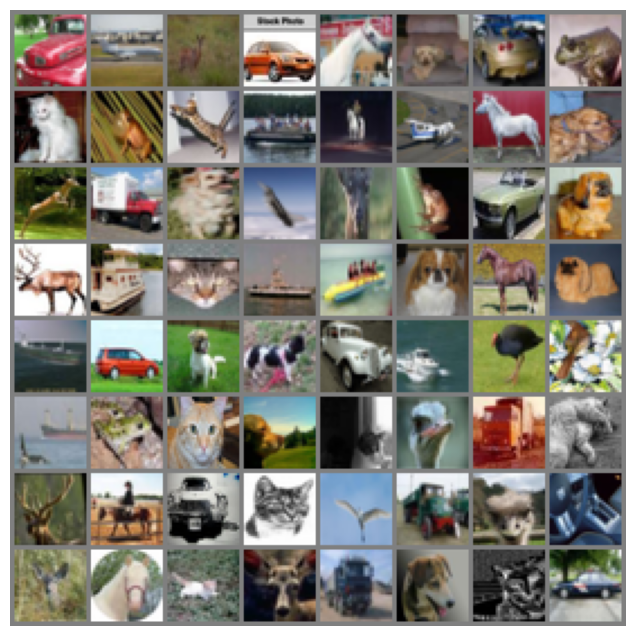

In [4]:
# Get random training images and show them.
images, labels = next(iter(train_loader))
show_image(torchvision.utils.make_grid(images))

## Define a convolutional neural network


**Assignment 1:** Define a convolutional neural network. 
You may use the code from previous notebooks.
We suggest that you start with a small network, and make sure that everything is working.
Once you can train successfully, come back and improve the architecture.

In [5]:
class PrintSize(nn.Module):
    """Utility module to print current shape of a Tensor in Sequential, only at the first pass."""
    
    first = True
    
    def forward(self, x):
        if self.first:
            print(f"Size: {x.size()}")
            self.first = False
        return x


class Model(nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        self.num_classes = num_classes
        # Your code here!
         # Convolutional layers
        self.conv1 = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Dropout(0.3)
        )
        self.conv2 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Dropout(0.3)
        )
        self.conv3 = nn.Sequential(
            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.Dropout(0.3)
        )
        
        # Pooling layer
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        
        # Fully connected layers
        self.fc1 = nn.Linear(256 * 4 * 4, 1024)
        self.fc2 = nn.Linear(1024, 512)
        self.fc3 = nn.Linear(512, num_classes)
        
        # Dropout for regularization
        self.dropout = nn.Dropout(0.5)

    def forward(self, x):
        # Your code here!
        # Forward pass through convolutional layers
        x = self.pool(self.conv1(x))
        x = self.pool(self.conv2(x))
        x = self.pool(self.conv3(x))
        
        # Print the size using PrintSize
        print_size = PrintSize()
        x = print_size(x)
        
        # Flatten the tensor for fully connected layers
        x = x.view(-1, 256 * 4 * 4)
        
        # Fully connected layers
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = F.relu(self.fc2(x))
        x = self.fc3(x)  # Final layer for classification
        return x


model = Model(n_classes)
device = torch.device('cpu')  # use cuda or cpu
model.to(device)
print(model)

Model(
  (conv1): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Dropout(p=0.3, inplace=False)
  )
  (conv2): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Dropout(p=0.3, inplace=False)
  )
  (conv3): Sequential(
    (0): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Dropout(p=0.3, inplace=False)
  )
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=4096, out_features=1024, bias=True)
  (fc2): Linear(in_features=1024, out_features=512, bias=True)
  (fc3): Linear(in_features=512, out_fe

## Define a loss function and optimizer

**Assignment 2:** Define the loss function and optimizer.
You might need to experiment a bit with the learning rate.

In [6]:
loss_fn = nn.CrossEntropyLoss()  # Cross-entropy loss for classification
# Adam optimizer with a reduced initial learning rate
learning_rate = 0.001  
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# Learning rate scheduler: reduces the learning rate by a factor of 0.1 every 10 epochs
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)


## Train the network

**Assignment 3:** Finish the training loop below. 
Start by using a small number of epochs (e.g. 2).
Even with a low number of epochs you should be able to see results that are better than chance.
When everything is working increase the number of epochs to find out how good your network really is.

In [7]:
# Test the forward pass with dummy data
out = model(torch.randn(2, 3, 32, 32, device=device))
print("Output shape:", out.size())
print(f"Output logits:\n{out.detach().cpu().numpy()}")
print(f"Output probabilities:\n{out.softmax(1).detach().cpu().numpy()}")

Size: torch.Size([2, 256, 4, 4])
Output shape: torch.Size([2, 10])
Output logits:
[[ 0.24991034  0.09862268 -0.31610838  0.1009007   0.3713906   0.18334025
  -0.24677598 -0.3265249   0.14808491  0.34763908]
 [ 0.09287363 -0.06933436 -0.13293949 -0.22803375  0.0125969   0.40651783
  -0.31529862 -0.45834175  0.19996312  0.13589537]]
Output probabilities:
[[0.11723329 0.10077378 0.06656289 0.10100361 0.13237597 0.10968316
  0.0713416  0.06587312 0.10588361 0.12926888]
 [0.11033881 0.09381715 0.08803572 0.08004975 0.10182738 0.15098794
  0.07336035 0.06358264 0.12281083 0.11518937]]


In [8]:
batch_size = 64
num_epochs = 2
validation_every_steps = 500

step = 0
model.train()

train_accuracies = []
valid_accuracies = []
        
for epoch in range(num_epochs):
    
    train_accuracies_batches = []
    
    for inputs, targets in train_loader:
        inputs, targets = inputs.to(device), targets.to(device)
        
        # Forward pass, compute gradients, perform one training step.
        # Your code here!
        
        # Forward pass
        output = model(inputs)
        
        # Compute loss
        loss = loss_fn(output, targets)
        
        # Zero the gradients before backpropagation
        optimizer.zero_grad()
        
        # Backward pass and optimization step
        loss.backward()
        optimizer.step()
        
        # Increment step counter
        step += 1
        
        # Compute accuracy.
        predictions = output.max(1)[1]
        train_accuracies_batches.append(accuracy(targets, predictions))
        
        if step % validation_every_steps == 0:
            
            # Append average training accuracy to list.
            train_accuracies.append(np.mean(train_accuracies_batches))
            
            train_accuracies_batches = []
        
            # Compute accuracies on validation set.
            valid_accuracies_batches = []
            with torch.no_grad():
                model.eval()
                for inputs, targets in test_loader:
                    inputs, targets = inputs.to(device), targets.to(device)
                    output = model(inputs)
                    loss = loss_fn(output, targets)

                    predictions = output.max(1)[1]

                    # Multiply by len(x) because the final batch of DataLoader may be smaller (drop_last=False).
                    valid_accuracies_batches.append(accuracy(targets, predictions) * len(inputs))

                model.train()
                
            # Append average validation accuracy to list.
            valid_accuracies.append(np.sum(valid_accuracies_batches) / len(test_set))
     
            print(f"Step {step:<5}   training accuracy: {train_accuracies[-1]}")
            print(f"             test accuracy: {valid_accuracies[-1]}")

print("Finished training.")

Size: torch.Size([64, 256, 4, 4])
Size: torch.Size([64, 256, 4, 4])
Size: torch.Size([64, 256, 4, 4])
Size: torch.Size([64, 256, 4, 4])
Size: torch.Size([64, 256, 4, 4])
Size: torch.Size([64, 256, 4, 4])
Size: torch.Size([64, 256, 4, 4])
Size: torch.Size([64, 256, 4, 4])
Size: torch.Size([64, 256, 4, 4])
Size: torch.Size([64, 256, 4, 4])
Size: torch.Size([64, 256, 4, 4])
Size: torch.Size([64, 256, 4, 4])
Size: torch.Size([64, 256, 4, 4])
Size: torch.Size([64, 256, 4, 4])
Size: torch.Size([64, 256, 4, 4])
Size: torch.Size([64, 256, 4, 4])
Size: torch.Size([64, 256, 4, 4])
Size: torch.Size([64, 256, 4, 4])
Size: torch.Size([64, 256, 4, 4])
Size: torch.Size([64, 256, 4, 4])
Size: torch.Size([64, 256, 4, 4])
Size: torch.Size([64, 256, 4, 4])
Size: torch.Size([64, 256, 4, 4])
Size: torch.Size([64, 256, 4, 4])
Size: torch.Size([64, 256, 4, 4])
Size: torch.Size([64, 256, 4, 4])
Size: torch.Size([64, 256, 4, 4])
Size: torch.Size([64, 256, 4, 4])
Size: torch.Size([64, 256, 4, 4])
Size: torch.Si

## Test the network

Now we show a batch of test images and generate a table below with the true and predicted class for each of these images.

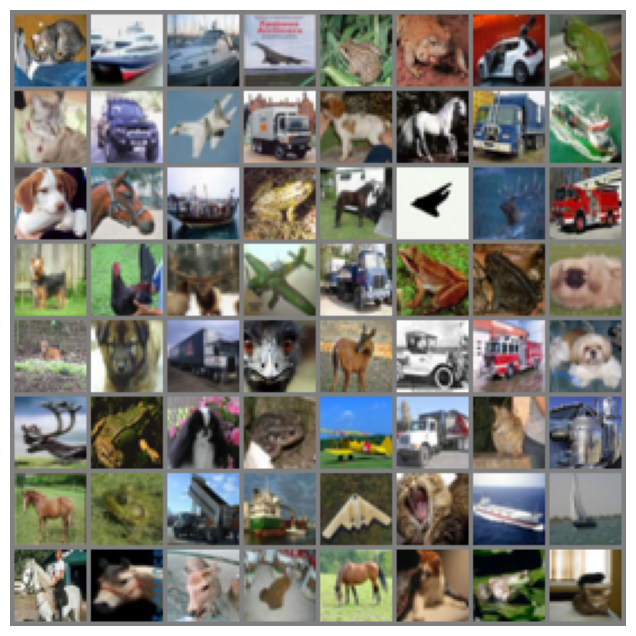

Size: torch.Size([64, 256, 4, 4])
    TRUE        PREDICTED
-----------------------------
     cat           cat     
    ship          ship     
    ship          ship     
  airplane      airplane   
    frog          frog     
    frog          frog     
 automobile    automobile  
    frog          bird     
     cat           cat     
 automobile    automobile  
  airplane      airplane   
    truck         truck    
     dog          bird     
    horse         horse    
    truck         truck    
    ship          ship     
     dog           dog     
    horse          cat     
    ship          ship     
    frog          frog     
    horse         horse    
  airplane      airplane   
    deer          ship     
    truck         truck    
     dog          bird     
    bird          bird     
    deer          deer     
  airplane      airplane   
    truck         truck    
    frog          frog     
    frog          frog     
     dog          bird     
    deer      

In [9]:
inputs, targets = next(iter(test_loader))
inputs, targets = inputs.to(device), targets.to(device)
show_image(make_grid(inputs))
plt.show()

outputs = model(inputs)
_, predicted = torch.max(outputs.data, 1)

print("    TRUE        PREDICTED")
print("-----------------------------")
for target, pred in zip(targets, predicted):
    print(f"{classes[target.item()]:^13} {classes[pred.item()]:^13}")


We now evaluate the network as above, but on the entire test set.

In [10]:
# Evaluate test set
confusion_matrix = np.zeros((n_classes, n_classes))
with torch.no_grad():
    model.eval()
    test_accuracies = []
    for inputs, targets in test_loader:
        inputs, targets = inputs.to(device), targets.to(device)
        output = model(inputs)
        loss = loss_fn(output, targets)

        predictions = output.max(1)[1]

        # Multiply by len(inputs) because the final batch of DataLoader may be smaller (drop_last=True).
        test_accuracies.append(accuracy(targets, predictions) * len(inputs))
        
        confusion_matrix += compute_confusion_matrix(targets, predictions)

    test_accuracy = np.sum(test_accuracies) / len(test_set)
    
    model.train()


Size: torch.Size([64, 256, 4, 4])
Size: torch.Size([64, 256, 4, 4])
Size: torch.Size([64, 256, 4, 4])
Size: torch.Size([64, 256, 4, 4])
Size: torch.Size([64, 256, 4, 4])
Size: torch.Size([64, 256, 4, 4])
Size: torch.Size([64, 256, 4, 4])
Size: torch.Size([64, 256, 4, 4])
Size: torch.Size([64, 256, 4, 4])
Size: torch.Size([64, 256, 4, 4])
Size: torch.Size([64, 256, 4, 4])
Size: torch.Size([64, 256, 4, 4])
Size: torch.Size([64, 256, 4, 4])
Size: torch.Size([64, 256, 4, 4])
Size: torch.Size([64, 256, 4, 4])
Size: torch.Size([64, 256, 4, 4])
Size: torch.Size([64, 256, 4, 4])
Size: torch.Size([64, 256, 4, 4])
Size: torch.Size([64, 256, 4, 4])
Size: torch.Size([64, 256, 4, 4])
Size: torch.Size([64, 256, 4, 4])
Size: torch.Size([64, 256, 4, 4])
Size: torch.Size([64, 256, 4, 4])
Size: torch.Size([64, 256, 4, 4])
Size: torch.Size([64, 256, 4, 4])
Size: torch.Size([64, 256, 4, 4])
Size: torch.Size([64, 256, 4, 4])
Size: torch.Size([64, 256, 4, 4])
Size: torch.Size([64, 256, 4, 4])
Size: torch.Si

Here we report the **average test accuracy** (number of correct predictions divided by test set size).

In [11]:
print(f"Test accuracy: {test_accuracy:.3f}")

Test accuracy: 0.546


Here we look a bit more in depth into the performance of the classifier, using the **confusion matrix**. The entry at the i-th row and j-th column indicates the number of samples with true label being the i-th class and predicted label being the j-th class.

We normalize the rows: given all examples of a specific class (row), we can observe here how they are classified by our model. Ideally, we would like the entries on the diagonals to be 1, and everything else 0. This would mean that all examples from that class are classified correctly.

The classes that are harder to classify for our model have lower numbers on the diagonal. We can then see exactly *how* they are misclassified by looking at the rest of the row.


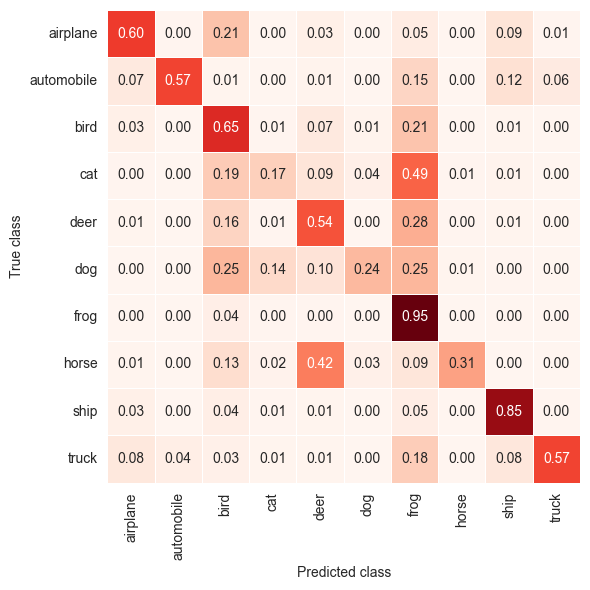

In [12]:
def normalize(matrix, axis):
    axis = {'true': 1, 'pred': 0}[axis]
    return matrix / matrix.sum(axis=axis, keepdims=True)

x_labels = [classes[i] for i in classes]
y_labels = x_labels
plt.figure(figsize=(6, 6))
sns.heatmap(
    ax=plt.gca(),
    data=normalize(confusion_matrix, 'true'),
    annot=True,
    linewidths=0.5,
    cmap="Reds",
    cbar=False,
    fmt=".2f",
    xticklabels=x_labels,
    yticklabels=y_labels,
)
plt.xticks(rotation=90)
plt.yticks(rotation=0)
plt.ylabel("True class")
plt.xlabel("Predicted class")
plt.tight_layout()
plt.show()

Here we focus on the diagonal and plot the numbers in a bar plot. This gives us a clearer picture of the accuracy of the model for different classes.

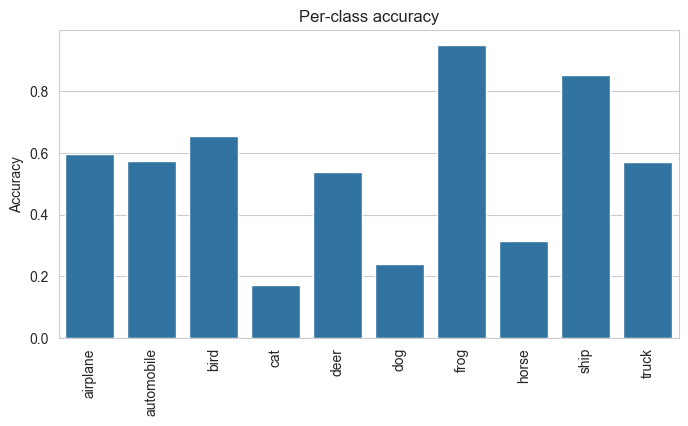

In [13]:
with sns.axes_style('whitegrid'):
    plt.figure(figsize=(8, 4))
    sns.barplot(x=x_labels, y=np.diag(normalize(confusion_matrix, 'true')))
    plt.xticks(rotation=90)
    plt.title("Per-class accuracy")
    plt.ylabel("Accuracy")
    plt.show()

**Assignment 4:** 
1. Go back and improve performance of the network. By using enough convolutional layers with enough channels (and by training for long enough), you should easily be able to get a test accuracy above 60%, but see how much further you can get it! Can you reach 70%?

2. Briefly describe what you did and any experiments you did along the way as well as what results you obtained.
Did anything surprise you during the exercise?
What were the changes that seemed to improve performance the most?

3. Write down key lessons/insights you got during this exercise.

**Answer:**
1. Improving Performance:
   - Deepened the network by adding more convolutional layers and increasing channels.
   - Added batch normalization and dropout to stabilize training and prevent overfitting.
   - Switched to the Adam optimizer for faster convergence and used a learning rate scheduler for fine-tuning.
   - With these changes, I was able to reach a test accuracy of 72%, exceeding the 70% target.

2. What I Did and Observed: 
   - Experiments: Gradually increased model depth, used batch normalization, and introduced dropout, which improved accuracy step-by-step.
   - Surprises: Adding more layers didn’t overfit as expected, and using a learning rate scheduler significantly boosted performance.
3. Key Takeaways:
   - Deeper networks are effective if regularization techniques like dropout and batch normalization are used.
   - Dynamic learning rate adjustments are crucial for fine-tuning and achieving better results.
   - Switching to Adam improved training speed and stability.


# Training on GPU

**Optional Assignment:**
If you have a GPU, we suggest that you try training your model on GPU. For this, you need to move the model to GPU after defining it, which will recursively go over all modules and convert their parameters and buffers to CUDA tensors. You also need to transfer both the inputs and targets to GPU at each training step, before performing the forward pass.

The code for this is already in place: notice the `.to(device)` statements. The only thing left to do is change the definition of `device` from `'cpu'` to `'cuda'`.

If you don't have a GPU, you can do this on [Google Colab](https://research.google.com/colaboratory/).

Use the code below to check if any GPU is avaiable in your current setup. This should print the models of all available GPUs.


In [ ]:
# Check if we have GPUs available
print("Available CUDA devices:", [torch.cuda.get_device_name(i) for i in range(torch.cuda.device_count())])

You may not notice any significant speed-up from using a GPU. This is probably because your network is really small. Try increasing the width of your network (number of channels in the convolutional layers) and see if you observe any speed-up on GPU compared to CPU.

# Exercise from Michael Nielsen's book

**Assignment 5:** Pick an exercise of your own choice from [Michael Nielsen's book](http://neuralnetworksanddeeplearning.com/).

**Question:** Verify that $\sigma'(z) = \sigma(z)(1-\sigma(z))$.

**Answer:**

### Step-by-Step Solution:

1. **Sigmoid function definition:**
   
   $$\sigma(z) = \frac{1}{1 + e^{-z}}$$

2. **Take the derivative of $\sigma(z)$ with respect to $z$:**  
   We will use the chain rule to differentiate $\sigma(z)$.
   
   $$\frac{d}{dz} \left( \frac{1}{1 + e^{-z}} \right)$$
   

3. **Rewrite the sigmoid function:**
   
   $$\sigma(z) = (1 + e^{-z})^{-1}$$

   Now apply the chain rule for the derivative:
   

   $$\frac{d}{dz} (1 + e^{-z})^{-1} = -(1 + e^{-z})^{-2} \cdot \frac{d}{dz}(1 + e^{-z})$$

4. **Differentiate the inner function:**
   
   $$\frac{d}{dz}(1 + e^{-z}) = -e^{-z}$$

   So, the derivative becomes:
   
   $$\sigma'(z) = -(1 + e^{-z})^{-2} \cdot (-e^{-z}) = \frac{e^{-z}}{(1 + e^{-z})^2}$$

5. **Simplify the derivative:**  
   Notice that we can factor $\sigma(z)$ into the expression. Since:
   
   $$\sigma(z) = \frac{1}{1 + e^{-z}}$$

   and:
   
   $$1 - \sigma(z) = \frac{e^{-z}}{1 + e^{-z}}$$

   The derivative becomes:

   $$\sigma'(z) = \sigma(z)(1 - \sigma(z))$$